#### Initially, we conduct data manipulation scrutinizing the trip dataset for missing values. We erase every row in which 'tripduration' is 'nan'. Next, we calculate detailed quantiles and percentiles for trip durations to understand the range and distribution, particularly targeting and filtering out extreme outliers to refine the data quality. Subsequent steps convert time fields to datetime format for temporal analysis and encode categorical variables. We provide visualizations such as histograms showcasing trip duration and user age distributions. Then, the elbow method is used to find the optimal number of clusters to be used in K-means based on the starting bike station locations. Additionally the cluster with the highest demand is identified while the analysis wraps up by breaking down the bike trip data into hours, showing when and where bikes are picked up and returned. Thus, we are ready to continue the project by implementing supervised learning techniques and make predictions.

In [5]:
import pandas as pd
import numpy as np
import folium
import os
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder

In [6]:
df = pd.read_csv("Trips_2018.csv")

In [7]:
dfplus=df.copy()

## 1.Preprocessing

### 1.1 Checking for possible null values in order to remove them

In [8]:
df[df.isnull().any(axis=1)] 

,Unnamed: 0,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender
10413518,10413518,2544,2018-08-15 11:31:37.8670,2018-08-15 12:14:02.1290,NaN,40.857,-73.890,NaN,40.857,-73.890,34426,Subscriber,1971,2
10413697,10413697,2004,2018-08-15 11:35:26.0140,2018-08-15 12:08:50.0360,NaN,40.857,-73.890,NaN,40.857,-73.887,34428,Subscriber,1976,2
10415434,10415434,213,2018-08-15 12:10:37.4360,2018-08-15 12:14:11.2920,NaN,40.857,-73.890,NaN,40.857,-73.890,34428,Subscriber,1976,2
10415668,10415668,602,2018-08-15 12:15:17.3330,2018-08-15 12:25:19.7620,NaN,40.845,-73.902,NaN,40.857,-73.890,34525,Subscriber,1988,1
10417031,10417031,511502,2018-08-15 12:41:41.9690,2018-08-21 10:46:44.6440,NaN,40.857,-73.890,NaN,40.857,-73.890,34548,Subscriber,1986,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17390711,17390711,589,2018-12-24 14:22:12.3950,2018-12-24 14:32:01.6410,NaN,40.863,-73.899,NaN,40.860,-73.905,34463,Subscriber,1986,2
17393046,17393046,362,2018-12-24 15:34:09.8420,2018-12-24 15:40:12.1510,NaN,40.860,-73.905,NaN,40.863,-73.902,34463,Subscriber,1986,2
17393363,17393363,276,2018-12-24 15:44:26.6440,2018-12-24 15:49:03.3450,NaN,40.863,-73.902,NaN,40.860,-73.902,34463,Subscriber,1986,2
17423361,17423361,626,2018-12-26 15:08:40.3100,2018-12-26 15:19:06.8170,NaN,40.860,-73.905,NaN,40.845,-73.914,34463,Subscriber,1991,1


In [9]:
df.shape

(17548339, 14)

In [10]:
df.drop(df['Unnamed: 0'])

,Unnamed: 0,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender


In [11]:
df = df.dropna(subset=['start_station_id'])

In [12]:
## Checking for null values left
df[df.isnull().any(axis=1)] 

,Unnamed: 0,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender


In [9]:
df.shape

(17545842, 14)

Additionally, some start_station ids might appear for more than one location indicating that there might be false data about some of them. Thus, we are going to find the possible longtitude-latitudes for each start station id and keep the ones with the most data.


In [18]:
# Group by 'start_station_id' and count the unique latitudes and longitudes
unique_location_counts = df.groupby('start_station_id').agg({
    'start_station_latitude': 'nunique',
    'start_station_longitude': 'nunique'
}).reset_index()


# Find station IDs with more than one unique latitude or longitude
stations_with_multiple_locations = unique_location_counts[
    (unique_location_counts['start_station_latitude'] > 1) | 
    (unique_location_counts['start_station_longitude'] > 1)
]

print(stations_with_multiple_locations)


     start_station_id  start_station_latitude  start_station_longitude
268             530.0                       2                        2


In [20]:
import pandas as pd

# Assuming df is your DataFrame and different_locations is a DataFrame containing station IDs with multiple locations

for station_id in different_locations['start_station_id']:
    print(f"Station ID: {station_id}")
    # Filter the DataFrame for the specific start_station_id
    station_data = df[df['start_station_id'] == station_id]
    
    # Group by both latitude and longitude, then count the occurrences
    lat_long_counts = station_data.groupby(['start_station_latitude', 'start_station_longitude']).size().reset_index(name='count')
    
    # Print the unique latitudes and longitudes along with their counts
    for _, row in lat_long_counts.iterrows():
        print(f"Latitude: {row['start_station_latitude']}, Longitude: {row['start_station_longitude']} - Count: {row['count']}")
    
    print("\n")  # Print a newline for better readability between station IDs



Station ID: 530.0
Latitude: 40.771496710544405, Longitude: -73.99046033620834 - Count: 2542.0
Latitude: 40.771522, Longitude: -73.99054100000001 - Count: 42931.0




It appears that the difference is minimal and thus it will not affect the result of the clustering in any way.

In [21]:
location_counts = df.groupby(['start_station_id', 'start_station_latitude', 'start_station_longitude']).size().reset_index(name='count')

# Sort the results for better readability (optional)
location_counts_sorted = location_counts.sort_values(by=['start_station_id', 'count'], ascending=[True, False])

print(location_counts_sorted)

     start_station_id  start_station_latitude  start_station_longitude  count
0                72.0               40.767272               -73.993929  38405
1                79.0               40.719116               -74.006667  27198
2                82.0               40.711174               -74.000165  10217
3                83.0               40.683826               -73.976323  13134
4               119.0               40.696089               -73.978034   3241
..                ...                     ...                      ...    ...
814            3716.0               40.753599               -73.937956    107
815            3718.0               40.727464               -73.979504   2014
816            3719.0               40.683223               -73.973812    222
817            3720.0               40.684617               -73.987213     62
818            3721.0               40.767549               -73.920933    238

[819 rows x 4 columns]


Some key statistics of the data are printed to get a better idea of the value distribution.

The dataset contains a total of 17,545,840 trip duration records with a mean of 988 sec (~16.47min) and a median of 605 seconds(~10min) -which is less affected by outliers- indicating a short typical trip. The standard deviation is around 18,9x10^3 sec that suggests that there is a significant variation in trip durations. 

Additionally, 25% of the trips have a duration of 358 seconds or less while 75% have less or equal to 1060 sec. We can also observe that the min and max values seem extreme since they account for 61sec and 225days correspondingly.

The presence of such a high maximum value and a large standard deviation suggests that there may be extreme outliers in the dataset. 
   


In [ ]:
df['tripduration'].describe()

count    1.754584e+07
mean     9.884746e+02
std      1.889591e+04
min      6.100000e+01
25%      3.580000e+02
50%      6.050000e+02
75%      1.060000e+03
max      1.951005e+07
Name: tripduration, dtype: float64

In [ ]:
# Find min and 0.1, 0.5, 0.1 quantile of trip duration along with thenumber of points for each one of them
print(df['tripduration'].quantile([.1, .05, .02, .01, .001, .0001, .00001]))
# Find the 90,95,98,99 percentile of trip duration
print(df['tripduration'].quantile([.90,.95,.98,.99,.999,.9999,.99999]))

0.10000    226.0
0.05000    171.0
0.02000    124.0
0.01000    101.0
0.00100     67.0
0.00010     61.0
0.00001     61.0
Name: tripduration, dtype: float64
0.90000    1.656000e+03
0.95000    2.075000e+03
0.98000    2.660000e+03
0.99000    3.505000e+03
0.99900    1.580800e+04
0.99990    3.080817e+05
0.99999    2.261573e+06
Name: tripduration, dtype: float64


##### We can see that the 99th percentile accounts for ~3500sec which even though it is significantly more than the mean and median values, is a value that makes sence (58minutes of bike rental is realistic)

In [ ]:
# Calculate the 0.1st and 999th percentiles
percentile_01 = df['tripduration'].quantile(0.001)
percentile_99 = df['tripduration'].quantile(0.999)
# i want to print the tripdurations of those who are in the 1st and 99th percentile
print('trip_durations :', percentile_01, percentile_99)

# Filter data based on percentiles
points_within_1_percentile = df[df['tripduration'] <= percentile_01]
points_within_99_percentile = df[df['tripduration'] >= percentile_99]

trip_durations : 67.0 15808.0


In [ ]:
print(f"Number of points in the 1st percentile: {len(points_within_1_percentile)}")
print(f"Number of points in the 99th percentile: {len(points_within_99_percentile)}")

Number of points in the 1st percentile: 20565
Number of points in the 99th percentile: 17548


##### Around 0.2% of the data is excluded

In [ ]:
df = df[df['tripduration'] > percentile_01]
df = df[df['tripduration'] < percentile_99]

In [ ]:
df.shape

(17507729, 14)

### 1.2 Transforming the data

In [ ]:
df['starttime']=pd.to_datetime(df['starttime'], format="%Y-%m-%d %H:%M:%S.%f")
df['stoptime']=pd.to_datetime(df['stoptime'], format="%Y-%m-%d %H:%M:%S.%f")

# Encode the 'usertype' column from string to int
label_encoder = LabelEncoder()
df['usertype'] = label_encoder.fit_transform(df['usertype'])

#df = df.dropna(subset=['start_station_id', 'end_station_id'])

# Transforming the 'start_station_id' and 'end_station_id' columns from float to int
df['start_station_id'] = df['start_station_id'].astype(int)
df['end_station_id'] = df['end_station_id'].astype(int)

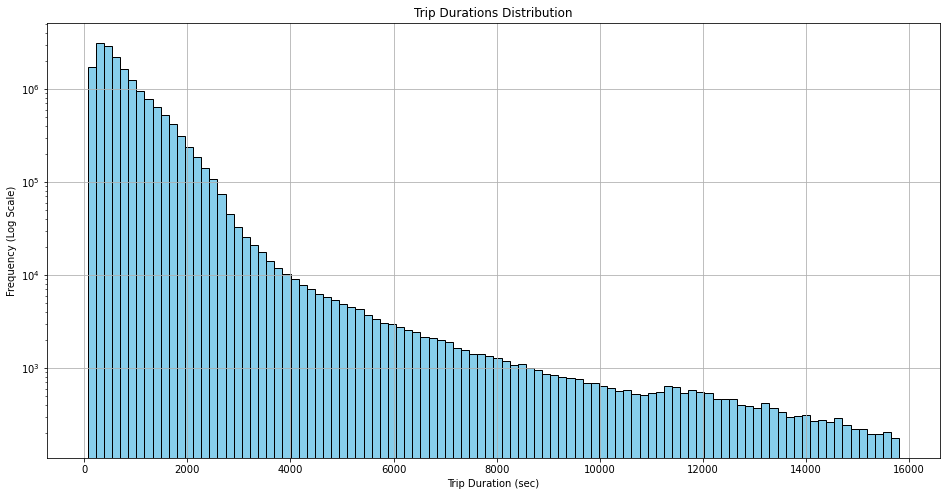

In [ ]:
## Plot of the distribution of trip durations
trip_durations = df['tripduration']

plt.figure(figsize=(16, 8))
plt.hist(trip_durations, bins=100, color='skyblue', edgecolor='black')
plt.yscale('log')
plt.title('Trip Durations Distribution')
plt.xlabel('Trip Duration (sec)')
plt.ylabel('Frequency (Log Scale)')
plt.grid(True)
plt.show()

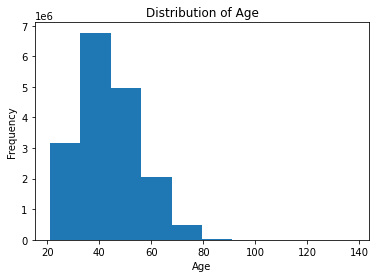

In [ ]:
# Plot of the associationg between trip duration and age
plt.hist(2023 - df['birth_year'], bins=10) # bins
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Distribution of Age')
plt.show()

## 2. Clustering

##### The Elbow method provides the optimal amount of clusters to be used as an input of K-means, by calculating the inertia


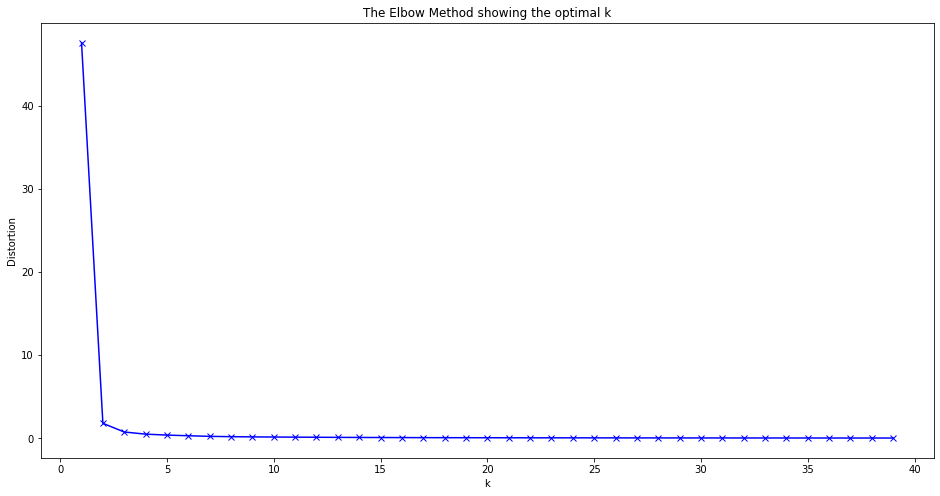

In [ ]:
distortions = []

stations = df[['start_station_id', 'start_station_latitude', 'start_station_longitude']].drop_duplicates()

K = range(1, 40) 
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(stations[['start_station_latitude', 'start_station_longitude']])
    distortions.append(kmeanModel.inertia_)

# Plotting the elbow curve
plt.figure(figsize=(16, 8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

##### It seems like the optimal number for clustering would be less that 5 and thus we don't need to choose more than 20 which is part of the objective of this project

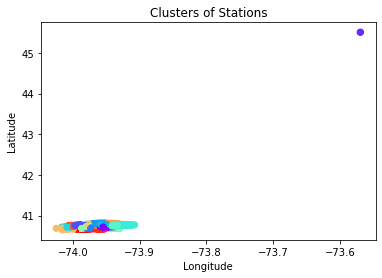

In [ ]:
## Implementing K-Means Clustering with k=20
kmeans = KMeans(n_clusters=20, random_state=0).fit(stations[['start_station_latitude', 'start_station_longitude']])
stations['cluster'] = kmeans.labels_

plt.scatter(stations['start_station_longitude'], stations['start_station_latitude'], c=stations['cluster'], cmap='rainbow')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Clusters of Stations')
plt.show()

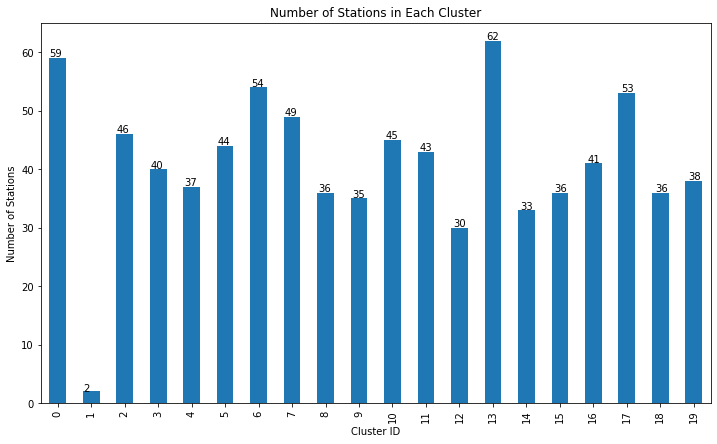

In [ ]:
cluster_counts = stations.groupby('cluster').size()

ax = cluster_counts.plot(kind='bar', figsize=(12,7))
plt.xlabel('Cluster ID')
plt.ylabel('Number of Stations')
plt.title('Number of Stations in Each Cluster')

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

plt.show()

In [ ]:
cluster_1_stations = stations[stations['cluster'] == 1]
print(cluster_1_stations)

        start_station_id  start_station_latitude  start_station_longitude  \
676612              3488               45.506364               -73.569463   
714486              3650               45.506264               -73.568906   

        cluster  
676612        1  
714486        1  


##### It can be observed that cluster's one stations, appear to be outliers and by looking at their coordinates, it seems that they are located in Canada and thus can be discarded.

In [ ]:
# Keep only the stations that are not in cluster 1
stations = stations[stations['cluster'] != 1]

In [ ]:
# Add an extra column to the dataframe with the cluster ID
merged_df = df.merge(stations[['start_station_id', 'cluster']], on='start_station_id', how='left')

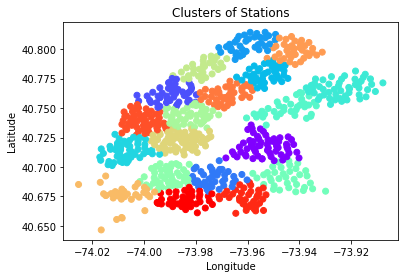

In [ ]:
# Plot of the distribution of stations among clusters
plt.scatter(stations['start_station_longitude'], stations['start_station_latitude'], c=stations['cluster'], cmap='rainbow')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Clusters of Stations')
plt.show()


In [ ]:
# Depiction of the stations in an actual interactive map

num_clusters = stations['cluster'].nunique()

colors = sns.color_palette("husl", num_clusters)  # This returns RGB values between 0 and 1
color_palette = {cluster: colors[i] for i, cluster in enumerate(stations['cluster'].unique())}

colors = sns.color_palette("husl", num_clusters)  # This returns RGB values between 0 and 1
color_palette = {cluster: colors[i] for i, cluster in enumerate(stations['cluster'].unique())}

# Create a base map
m = folium.Map(location=[stations['start_station_latitude'].mean(), stations['start_station_longitude'].mean()], zoom_start=13)

# Add markers for each station, color-coded by their cluster
for index, row in stations.iterrows():
    cluster_color = color_palette[row['cluster']]
    folium.CircleMarker(
        location=(row['start_station_latitude'], row['start_station_longitude']),
        radius=5,
        color=mcolors.rgb2hex(cluster_color),  # Convert RGB to hex format
        popup=f"ID: {row['start_station_id']}<br>Cluster: {row['cluster']}",
        fill=True,
        fill_color=mcolors.rgb2hex(cluster_color)
    ).add_to(m)

m

##### Here, the cluster with the highest demand in terms of departures is identified.

In [ ]:
# Calculate total demand (arrivals) for each cluster
cluster_demand = merged_df.groupby('cluster').size()

# Find the cluster with the highest demand
cluster_highest_demand = cluster_demand.idxmax()

# Create a new DataFrame with data points only from the cluster with the highest demand
df_onecluster = merged_df[merged_df['cluster'] == cluster_highest_demand]

df_onecluster['cluster'].unique()
df_onecluster.head()

,Unnamed: 0,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,cluster,start_hour,stop_hour
4181,4183,1176,2018-01-01 01:11:58.481,2018-01-01 01:31:34.729,127,40.731724,-74.006744,382,40.734927,-73.992005,25514,1,1979,2,17.0,2018-01-01 01:00:00,2018-01-01 01:00:00
4182,4184,1824,2018-01-01 01:12:26.474,2018-01-01 01:42:50.474,127,40.731724,-74.006744,530,40.771522,-73.990541,30370,1,1969,1,17.0,2018-01-01 01:00:00,2018-01-01 01:00:00
4183,4185,613,2018-01-01 09:55:37.097,2018-01-01 10:05:50.697,127,40.731724,-74.006744,3255,40.750585,-73.994685,25036,1,1966,1,17.0,2018-01-01 09:00:00,2018-01-01 10:00:00
4184,4186,463,2018-01-01 10:27:30.491,2018-01-01 10:35:13.638,127,40.731724,-74.006744,229,40.727434,-73.993790,33019,1,1992,1,17.0,2018-01-01 10:00:00,2018-01-01 10:00:00
4185,4187,454,2018-01-01 10:27:52.262,2018-01-01 10:35:26.884,127,40.731724,-74.006744,229,40.727434,-73.993790,27221,1,1991,2,17.0,2018-01-01 10:00:00,2018-01-01 10:00:00


##### Cluster 17 is the one with the highest demand

In [ ]:
merged_df['start_hour'] = merged_df['starttime'].dt.strftime('%Y-%m-%d %H:00:00')
merged_df['stop_hour'] = merged_df['stoptime'].dt.strftime('%Y-%m-%d %H:00:00')

pickups = merged_df.groupby(['start_hour', 'cluster']).size().reset_index(name='pickups')
dropoffs = merged_df.groupby(['stop_hour', 'cluster']).size().reset_index(name='dropoffs')

pickups = pickups.rename(columns={"start_hour": "hour"})
dropoffs = dropoffs.rename(columns={"stop_hour": "hour"})

hourly_data = pd.merge(pickups, dropoffs, on=['hour', 'cluster'], how='outer').fillna(0)

In [ ]:
hourly_data.head(20)

,hour,cluster,pickups,dropoffs
0,2018-01-01 00:00:00,0.0,9.0,6.0
1,2018-01-01 00:00:00,2.0,14.0,8.0
2,2018-01-01 00:00:00,3.0,2.0,2.0
3,2018-01-01 00:00:00,4.0,3.0,3.0
4,2018-01-01 00:00:00,5.0,7.0,7.0
5,2018-01-01 00:00:00,6.0,11.0,8.0
6,2018-01-01 00:00:00,7.0,2.0,2.0
7,2018-01-01 00:00:00,8.0,1.0,0.0
8,2018-01-01 00:00:00,9.0,3.0,3.0
9,2018-01-01 00:00:00,10.0,2.0,1.0


- Then we will pick the cluster with the highest demand based on pickups or based on pickups + dropoffs and implement normalization on the dataset

- The goal is to create a prediction model that finds the arrivals and departures for the next 24 hours (or one model for arrivals and one for departures).
Thus the demand(1-hour time intervals for 24 hours) of each next day will be the target for its previous one! For that purpose, we will add a 'target_arr_dep' or 'target_arriv' and 'target_dep' column/s, that will include the corresponding real value/s.

## 3. Prediction - Regression

Firstly we need to split our data into training and test (Data from January to October (included) to train
the model, and the data from November and December as a test set) with R2 of at least 0.60.

For the prediction part and after the dataset has the correct form, we will use 2-linear regression models(one for arrivals and one for dropoffs) as a baseline.
Then we will try to improve the results by using 2-polynomial regression models and a multi-regressor model or an LSTM neural network that works well with time series data.

After the prediction of arrivals and departures, the amount of bikes needed for the next day for that cluster will be calculated.

## Exploratory Component Analysis

...

import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Assuming df is your DataFrame and it's indexed by the datetime of the pickups/dropoffs
# Make sure your DataFrame is sorted chronologically
df.sort_index(inplace=True)

# Create lag features for the previous 24 hours
for i in range(1, 25):
    df[f'pickups_lag_{i}'] = df['pickups'].shift(i)
    df[f'dropoffs_lag_{i}'] = df['dropoffs'].shift(i)

# Shift the target values by 24 hours to create the prediction targets for the next day
df['pickups_target'] = df['pickups'].shift(-24)
df['dropoffs_target'] = df['dropoffs'].shift(-24)

# Remove the NaN values after shifting
df = df.dropna()

# Now, split your data into features (X) and targets (y)
# Exclude the last 24 hours since we don't have the target values for them
X = df.iloc[:-24, :-2]  # all data except the last 24 hours and excluding target columns
y_pickups = df.iloc[:-24]['pickups_target']  # the target for pickups
y_dropoffs = df.iloc[:-24]['dropoffs_target']  # the target for dropoffs

# Split the data into training and test sets
# Assuming you have a DateTimeIndex
train_data = df['2018-01-01':'2018-10-31']
test_data = df['2018-11-01':'2018-12-31']

X_train = train_data.iloc[:-24, :-2]
y_train_pickups = train_data.iloc[:-24]['pickups_target']
y_train_dropoffs = train_data.iloc[:-24]['dropoffs_target']

X_test = test_data.iloc[:-24, :-2]
y_test_pickups = test_data.iloc[:-24]['pickups_target']
y_test_dropoffs = test_data.iloc[:-24]['dropoffs_target']

# Initialize the regression models
model_pickups = LinearRegression()
model_dropoffs = LinearRegression()

# Train the models
model_pickups.fit(X_train, y_train_pickups)
model_dropoffs.fit(X_train, y_train_dropoffs)

# Make predictions
y_pred_pickups = model_pickups.predict(X_test)
y_pred_dropoffs = model_dropoffs.predict(X_test)

# Evaluate the models
mse_pickups = mean_squared_error(y_test_pickups, y_pred_pickups)
mse_dropoffs = mean_squared_error(y_test_dropoffs, y_pred_dropoffs)

print(f'Pickups Model MSE: {mse_pickups}')
print(f'Dropoffs Model MSE: {mse_dropoffs}')
